                               reviewId             userName  \
0  166731e8-4b10-4968-838d-329473357328       Sylviah Chichi   
1  68bab7d0-2afc-4454-970f-159ced93d751        Marilyn Goeda   
2  6c2d3e85-b5ca-4228-93bd-abd2236eab51            Nikhil Pk   
3  d62b0303-4c87-4c96-9c2c-a3ca6e0b056d  Mmesoma Eberechukwu   
4  d6014252-863e-4e06-b440-25e0ece47a31    Keabetswe Monaise   

                                             content  score  thumbsUpCount  \
0  Great App on the move ..... I can watch my mov...      5              0   
1                                               good      5              0   
2  Need to improve and to update some error durin...      3              0   
3  Netflix is a nice app,but not all the movies a...      3              0   
4  Not much availability considering options on w...      3              0   

    reviewCreatedVersion                   at             appVersion  
0  8.136.0 build 3 50908  2024-10-21 14:15:31  8.136.0 build 3 50908  
1   

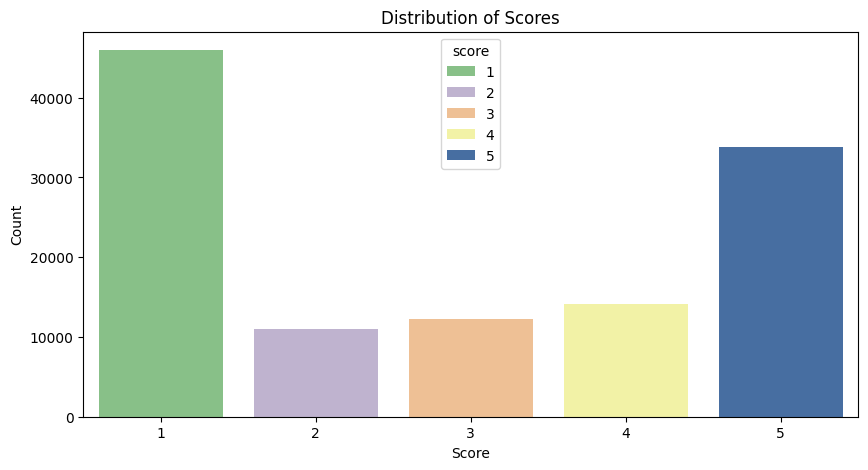

In [93]:

# 도전과제
#영화 리뷰 감성 분석
# 1. 데이터 셋 불러오기 - 데이터셋을 다운로드한 후에 데이터셋을 불러오고, 불러온 데이터프레임의 상단 5개의 데이터와 하단 5개의 데이터, 컬럼과 shape를 불러오는 코드를 작성해라.
import pandas as pd
df = pd.read_csv("netflix_reviews.csv")
print(df.head())
print(df.tail())
print("Shape of the dataset:",df.shape)
print("Columns in the dataset:",df.columns)
print("score:",df["score"].isnull().sum())
print("score sum:",df["score"].sum())
print("score 5점:",df["score"].value_counts())

#2. 데이터 전처리 - 텍스트 데이터에는 불용어(쓸모없는 단어, 구두점 등)가 많다. 해당 부분을 없애주는 처리가 필요하다. 텍스트 데이터에 대한 전처리를 해라.

# 전처리 함수
import re

text = lambda x: ""if isinstance(x, float) else re.sub(r'\d+', '', re.sub(r'[^\w\s]', '', x.lower())).strip()

for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].apply(text)

print(df.head())

#3. feature 분석 (EDA) - 데이터를 잘 불러오셨다면 해당 데이터의 feature를 찾아야 한다. 해당 넷플릭스의 데이터에는 리뷰가 1점부터 5점까지 있다. 해당 데이터의 분포를 그래프로 그려라. 

import seaborn as sns  # 그래프를 그리기 위한 seaborn 라이브러리 임포트 (없으면 설치 바랍니다)
import matplotlib.pyplot as plt  # 그래프 표시를 위한 pyplot 임포트

plt.figure(figsize= (10,5))
count = df['score'].value_counts().sort_index()
sns.barplot(x = count.index, y = count.values, hue=count.index, palette='Accent', )
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Distribution of Scores')
plt.show()

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117134 entries, 0 to 117133
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              117134 non-null  object
 1   userName              117134 non-null  object
 2   content               117134 non-null  object
 3   score                 117134 non-null  int64 
 4   thumbsUpCount         117134 non-null  int64 
 5   reviewCreatedVersion  117134 non-null  object
 6   at                    117134 non-null  object
 7   appVersion            117134 non-null  object
dtypes: int64(2), object(6)
memory usage: 7.1+ MB


In [95]:

#4. 리뷰 예측 모델 학습시키기 (LSTM) - 이제 어떤 리뷰를 쓰면 점수가 어떻게 나올지에 대해서 예측을 해보고 싶다. 로지스틱 회귀 등을 사용하여, 리뷰에 대한 점수 예측을 진행해라
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from torch.nn.utils.rnn import pad_sequence


#라벨인코더로 score 라벨화
label_encoder = LabelEncoder()
df["score"] = label_encoder.fit_transform(df["score"])

train_reviews, test_reviews, train_ratings, test_ratings = train_test_split(df["content"].values, df['score'].values, test_size=0.2, random_state=42)

# 자연어 처리
tokenizer = get_tokenizer("basic_english")
def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(df["content"]))

# 데이터셋 클래스 정의
class ReviewDataset(Dataset):
    def __init__(self, reviews, ratings, text_pipeline, label_pipeline):
        self.reviews = reviews
        self.ratings = ratings
        self.text_pipeline = text_pipeline
        self.label_pipeline = label_pipeline

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.text_pipeline(self.reviews[idx])
        rating = self.label_pipeline(self.ratings[idx])
        return torch.tensor(review, dtype=torch.long), torch.tensor(rating, dtype=torch.long)

def text_pipeline(text):
    tokens = tokenizer(text)
    return vocab(tokens)

def label_pipeline(label):
    return label


# 데이터셋 정의
train_dataset = ReviewDataset(train_reviews, train_ratings, text_pipeline, label_pipeline)
test_dataset = ReviewDataset(test_reviews, test_ratings, text_pipeline, label_pipeline)

# 데이터 로더 정의
BATCH_SIZE = 64

def collate_fn(batch):  # 배치 내 텍스트와 레이블을 패딩합니다.
    texts, labels = zip(*batch)  # 배치에서 텍스트와 레이블을 분리합니다.
    texts_padded = pad_sequence([torch.tensor(r, dtype=torch.long) for r in texts], batch_first=True)  # 텍스트를 패딩합니다.
    labels_tensor = torch.stack([label.clone().long() for label in labels])   # 레이블을 텐서로 변환합니다.
    return texts_padded, labels_tensor  #

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn = collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn = collate_fn)


In [96]:
# LSTM 모델 정의 
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)  # Embedding으로 변경
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cell) = self.lstm(embedded)
        return self.fc(hidden[-1])

# 하이퍼파라미터 정의
VOCAB_SIZE = len(vocab)
EMBED_DIM = 64
HIDDEN_DIM = 128
OUTPUT_DIM = 5 # 예측할 점수 개수

# 모델 초기화
model = LSTMModel(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM)

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# 모델 학습
num_epochs = 1  # 에포크 수 설정
for epoch in range(num_epochs):
    model.train()  # 모델을 훈련 모드로 설정
    total_loss = 0
    for i, (texts, labels) in enumerate(train_dataloader):  # 훈련 데이터로 반복
        optimizer.zero_grad()  # 기울기 초기화
        outputs = model(texts)  # 모델 출력 계산

        loss = criterion(outputs, labels)  # 손실 계산
        loss.backward()  # 역전파
        optimizer.step()  # 가중치 업데이트
        total_loss += loss.item()
        # 10 Step 마다 손실 출력
        if (i + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Step {i+1}/{len(train_dataloader)}, Loss: {loss.item():.4f}')

    print(f'Epoch {epoch+1}/{num_epochs}, Average Loss: {total_loss/len(train_dataloader):.4f}')  # 에포크와 손실 출력


    # 매 에포크 마다 모델 평가 실행
    correct = 0
    total = 0
    with torch.no_grad():  # 평가 시에는 기울기 계산을 하지 않음
        for texts, labels in test_dataloader:
            outputs = model(texts)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'에포크{epoch+1} - Accuracy: {100 * correct / total}%')


# 예측 함수(예시)
def predict_review(model, review):
    model.eval()
    with torch.no_grad():
        # 입력된 리뷰를 토큰화하고 vocab에 있는 단어만 필터링
        tokens = tokenizer(review)
        token_indices = [vocab[token] for token in tokens if token in vocab]  # vocab에 존재하는 토큰만 선택
        tensor_review = torch.tensor(token_indices, dtype=torch.long).unsqueeze(0)  # 텐서로 변환 및 배치 차원 추가
        output = model(tensor_review)
        prediction = output.argmax(1).item()
        return label_encoder.inverse_transform([prediction])[0]

# 새로운 리뷰에 대한 예측
new_review = "very good"
predicted_score = predict_review(model, new_review)
print(f'Predicted Score: {predicted_score}')

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_29700\1447534154.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  texts_padded = pad_sequence([torch.tensor(r, dtype=torch.long) for r in texts], batch_first=True)  # 텍스트를 패딩합니다.


Epoch 1/1, Step 10/1465, Loss: 1.3393
Epoch 1/1, Step 20/1465, Loss: 1.3379
Epoch 1/1, Step 30/1465, Loss: 1.3865
Epoch 1/1, Step 40/1465, Loss: 1.4198
Epoch 1/1, Step 50/1465, Loss: 1.4964
Epoch 1/1, Step 60/1465, Loss: 1.4863
Epoch 1/1, Step 70/1465, Loss: 1.5639
Epoch 1/1, Step 80/1465, Loss: 1.4432
Epoch 1/1, Step 90/1465, Loss: 1.4448
Epoch 1/1, Step 100/1465, Loss: 1.3926
Epoch 1/1, Step 110/1465, Loss: 1.3549
Epoch 1/1, Step 120/1465, Loss: 1.3829
Epoch 1/1, Step 130/1465, Loss: 1.5473
Epoch 1/1, Step 140/1465, Loss: 1.6132
Epoch 1/1, Step 150/1465, Loss: 1.4541
Epoch 1/1, Step 160/1465, Loss: 1.4910
Epoch 1/1, Step 170/1465, Loss: 1.4242
Epoch 1/1, Step 180/1465, Loss: 1.3506
Epoch 1/1, Step 190/1465, Loss: 1.4370
Epoch 1/1, Step 200/1465, Loss: 1.3661
Epoch 1/1, Step 210/1465, Loss: 1.4189
Epoch 1/1, Step 220/1465, Loss: 1.3546
Epoch 1/1, Step 230/1465, Loss: 1.3664
Epoch 1/1, Step 240/1465, Loss: 1.3577
Epoch 1/1, Step 250/1465, Loss: 1.4283
Epoch 1/1, Step 260/1465, Loss: 1.

In [100]:
import nltk
from textblob import TextBlob

# 토픽 모델링을 위한 라이브러리
import gensim
from gensim import corpora
from gensim.utils import simple_preprocess

# 감성 분석을 위한 함수
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

df['sentiment'] = df["content"].apply(get_sentiment)  # (DIY) apply를 사용하여 감성 분석을 해보세요. 필수 텍스트가 전처리되어있어야 합니다.
# df에 sentiment 값을 적용을 먼저 하시고, 아래와 같이 긍정과 부정을 분류하세요.
df['sentiment_label'] = df['sentiment'].apply(lambda x: 'positive' if x > 0.1 else ('negative' if x < -0.1 else 'neutral'))
df['score'] = df['score'] + 1
df[['content', 'score', 'sentiment_label']]

,content,score,sentiment_label
0,great app on the move i can watch my movies a...,5,positive
1,good,5,positive
2,need to improve and to update some error durin...,3,neutral
3,netflix is a nice appbut not all the movies ar...,3,neutral
4,not much availability considering options on w...,3,neutral
...,...,...,...
117129,i really like it there are so many movies and ...,5,positive
117130,i love netflix i always enjoy my time using it,5,positive
117131,sound quality is very slow of movies,1,neutral
117132,rate is very expensive bcos we see netflix sun...,1,negative


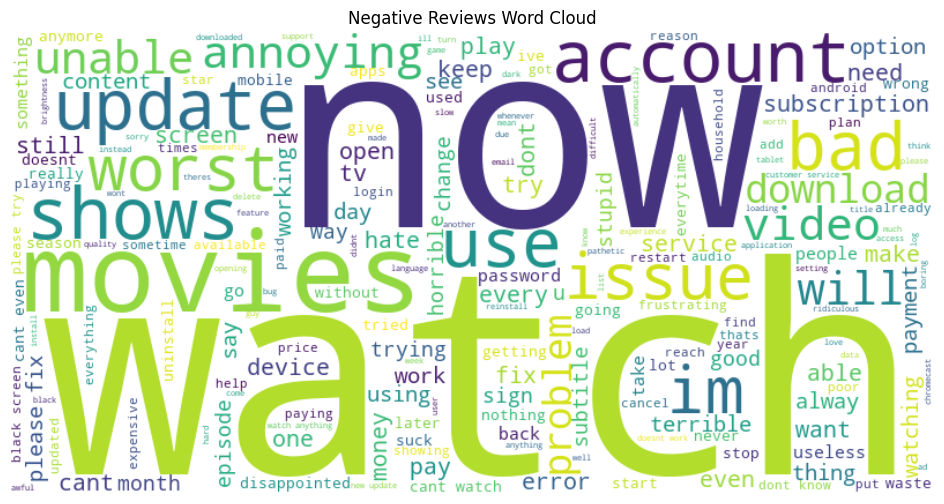

In [98]:
#6-1번 wordcloud 라이브러리를 설치하고, 부정의 워드 클라우드를 그려보라.
from wordcloud import WordCloud, STOPWORDS

# (선택) 불용어를 먼저 제거해주세요.
stopwords = set(STOPWORDS)
stopwords.update(['netflix', 'movie', 'show', 'time', 'app', 'series', 'phone'])  # 리뷰에서 필요없는 단어는 여기 안에 추가하셔도 좋습니다.

# 부정적인 리뷰만 먼저 모아본 다음, 아래처럼 wordcloud를 그려보세요
negative_reviews = ' '.join(df.loc[df["sentiment_label"] == "negative", "content"])
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(negative_reviews)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Reviews Word Cloud')
plt.show()

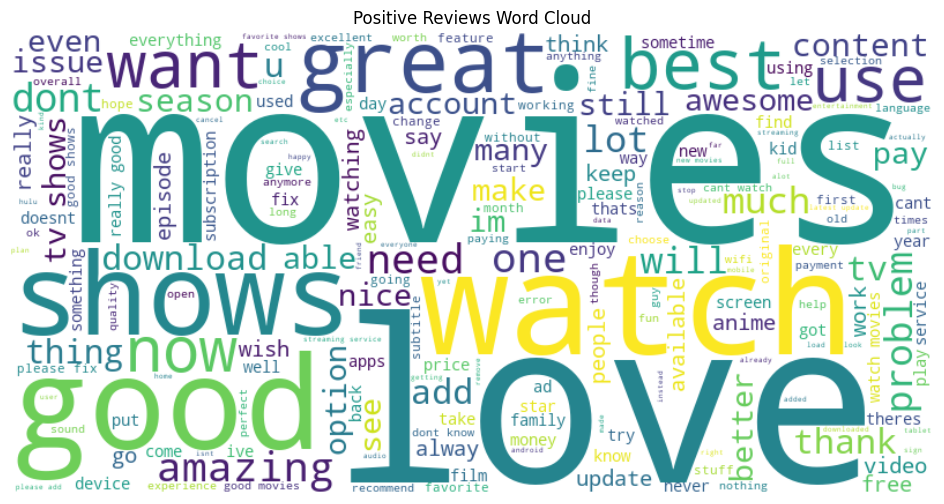

In [99]:
#6-2번 wordcloud 라이브러리를 설치하고, 긍정의 워드 클라우드를 그려보라.
from wordcloud import WordCloud, STOPWORDS

# (선택) 불용어를 먼저 제거해주세요.
stopwords = set(STOPWORDS)
stopwords.update(['netflix', 'movie', 'show', 'time', 'app', 'series', 'phone'])  # 리뷰에서 필요없는 단어는 여기 안에 추가하셔도 좋습니다.

# 긍정적인 리뷰만 먼저 모아본 다음, 아래처럼 wordcloud를 그려보세요
negative_reviews = ' '.join(df.loc[df["sentiment_label"] == "positive", "content"])
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(negative_reviews)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Reviews Word Cloud')
plt.show()